In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
import os
import seaborn as sns
import pandas as pd
from skimage.io import imshow, imread
from skimage.color import rgb2gray
from skimage.feature import hog
from sklearn.model_selection import train_test_split
import shutil
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [2]:
df= pd.read_csv('HAM10000_metadata',sep=',')
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern


In [3]:
df['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [4]:
df.shape

(10015, 8)

In [5]:
dataset_default_path = 'HAM10000_images_part_1'
train_set_path = 'dataset/train'
test_set_path = 'dataset/test'
min_samples = 200
rand_seed = 0

In [6]:
df_nv = df[df.dx=='nv']
df_mel = df[df.dx=='mel']
df_bkl = df[df.dx=='bkl']
df_bcc = df[df.dx=='bcc']


In [7]:
df_nv=df_nv.head(1000)

In [8]:
df_nv.shape

(1000, 8)

In [9]:
data =df_mel.append(df_nv, ignore_index=True)

In [10]:
data1= data.append(df_bkl,ignore_index=True)

df= data1.append(df_bcc,ignore_index=True)

In [11]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000871,ISIC_0025964,mel,histo,40.0,female,chest,vidir_modern
1,HAM_0000871,ISIC_0030623,mel,histo,40.0,female,chest,vidir_modern
2,HAM_0000040,ISIC_0027190,mel,histo,80.0,male,upper extremity,rosendahl
3,HAM_0005678,ISIC_0031023,mel,histo,60.0,male,chest,vidir_modern
4,HAM_0005678,ISIC_0028086,mel,histo,60.0,male,chest,vidir_modern


In [12]:
df.shape

(3726, 8)

In [13]:
df.dx.value_counts()

mel    1113
bkl    1099
nv     1000
bcc     514
Name: dx, dtype: int64

<AxesSubplot:xlabel='dx', ylabel='count'>

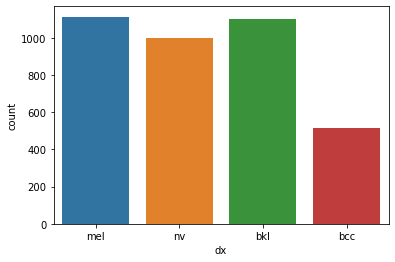

In [14]:
sns.countplot(df['dx'])

Text(0.5, 1.0, 'Histogram distribution of age')

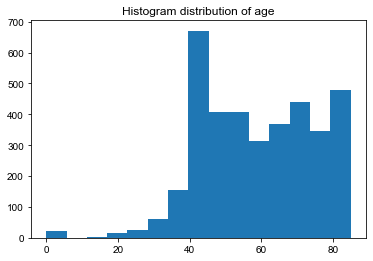

In [15]:
plt.hist(df['age'], bins = 15)
sns.set_theme()
plt.title('Histogram distribution of age')

# Pixel values distribution an image

Text(0, 0.5, '# Pixels in Image')

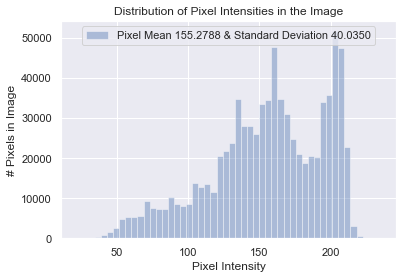

In [17]:
# Plot a histogram of the bkl class

raw_image = plt.imread('HAM10000_images_part_1/ISIC_0028977.jpg')


sns.distplot(raw_image.ravel(), 
             label=f'Pixel Mean {np.mean(raw_image):.4f} & Standard Deviation {np.std(raw_image):.4f}', kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

Text(0, 0.5, '# Pixels in Image')

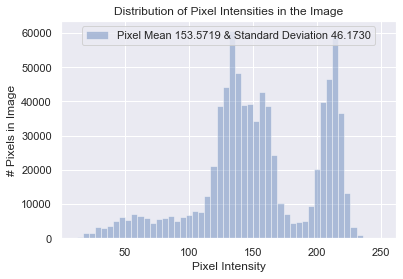

In [18]:
raw_image = plt.imread('HAM10000_images_part_1/ISIC_0026208.jpg')


sns.distplot(raw_image.ravel(), 
             label=f'Pixel Mean {np.mean(raw_image):.4f} & Standard Deviation {np.std(raw_image):.4f}', kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

Text(0, 0.5, '# Pixels in Image')

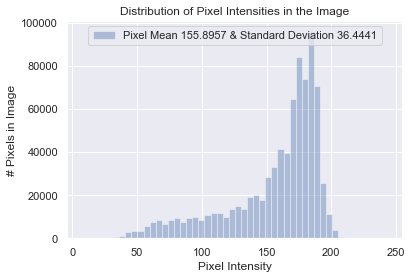

In [20]:
raw_image = plt.imread('HAM10000_images_part_2/ISIC_0033534.jpg')


sns.distplot(raw_image.ravel(), 
             label=f'Pixel Mean {np.mean(raw_image):.4f} & Standard Deviation {np.std(raw_image):.4f}', kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

Text(0, 0.5, '# Pixels in Image')

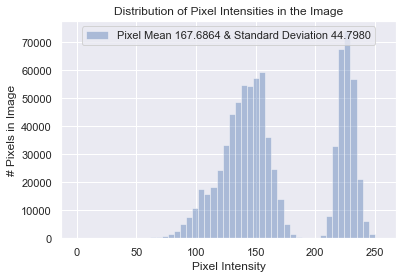

In [22]:
raw_image = plt.imread('HAM10000_images_part_1/ISIC_0026528.jpg')

sns.distplot(raw_image.ravel(), 
             label=f'Pixel Mean {np.mean(raw_image):.4f} & Standard Deviation {np.std(raw_image):.4f}', kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

In [23]:
df.to_csv('main_data.csv')

In [24]:
df.shape

(3726, 8)

In [20]:
def build_train_test(num_samples=0, train_set_frac=0.75, dataset_path=dataset_default_path,
                     train_path=train_set_path, test_path=test_set_path,
                     overwrite=False):


    if not os.path.isdir(dataset_path):
        dataset_path = dataset_default_path
    
    abs_dataset_path = os.path.abspath(dataset_path)

    if not os.path.isdir(train_path):
        train_path = train_set_path
    
    abs_train_path = os.path.abspath(train_path)
    if overwrite:
        shutil.rmtree(abs_train_path)
        os.mkdir(abs_train_path)

    if not os.path.isdir(test_path):
        test_path = test_set_path
    
    abs_test_path = os.path.abspath(test_path)
    if overwrite:
        shutil.rmtree(abs_test_path)
        os.mkdir(abs_test_path)

        
    ham10000_df = pd.read_csv('main_data.csv',sep=',')
    

    for img_idx in range(ham10000_df['image_id'].count()):
        ham10000_df.at[img_idx, 'image_id'] += '.jpg'

    classes = list(set(ham10000_df.dx))
    num_images = ham10000_df.image_id.count()

    if 0 < num_samples < min_samples:
        ham10000_df = ham10000_df.sample(n=min_samples, random_state=rand_seed)        
    elif num_samples > num_images:
        print('Warning')
        
    elif min_samples <= num_samples <= num_images:
        ham10000_df = ham10000_df.sample(n=num_samples, random_state=rand_seed)


    print(ham10000_df.dx.value_counts())

    if train_set_frac < 0 or train_set_frac > 1.0:
        test_set_frac = 0.75


    train_set, test_set = train_test_split(ham10000_df, train_size=train_set_frac,
                                           random_state=rand_seed,
                                           stratify=ham10000_df.dx)


    train_imgs = list(train_set['image_id'])
    test_imgs = list(test_set['image_id'])

    for img_name in train_imgs:
        src_path = os.path.join(abs_dataset_path, img_name)
        shutil.copy2(src_path, abs_train_path)

    for img_name in test_imgs:
        src_path = os.path.join(abs_dataset_path, img_name)
        shutil.copy2(src_path, abs_test_path)
  
    return train_set, test_set, classes

# Labels description



* basal cell carcinoma (bcc),
* benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl),
* melanoma (mel),
* melanocytic nevi (nv)


In [21]:
train_df, test_df, class_labels = build_train_test(num_samples=3726,
                                                   overwrite=True)

Class labels: ['bcc', 'bkl', 'mel', 'nv']
Number of images in the HAM10000 dataset: 3726
Number of images in the reduced dataset: 3726
Number of images for each class (dataset):
mel    1113
bkl    1099
nv     1000
bcc     514
Name: dx, dtype: int64

Number of images in the training set : 2794
Number of images for each class (training set):
mel    835
bkl    824
nv     750
bcc    385
Name: dx, dtype: int64

Number of images in the test set : 932
Number of images for each class (test set):
mel    278
bkl    275
nv     250
bcc    129
Name: dx, dtype: int64


In [22]:
main_data =train_df.append(test_df, ignore_index=True)

In [23]:
main_data.head()

,Unnamed: 0,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,3208,HAM_0006159,ISIC_0028977.jpg,bkl,consensus,50.0,female,upper extremity,vidir_modern
1,1984,HAM_0007201,ISIC_0026208.jpg,nv,follow_up,50.0,male,lower extremity,vidir_molemax
2,2550,HAM_0004889,ISIC_0028511.jpg,bkl,histo,75.0,male,upper extremity,rosendahl
3,1334,HAM_0003302,ISIC_0032434.jpg,nv,follow_up,70.0,male,lower extremity,vidir_molemax
4,643,HAM_0005953,ISIC_0033534.jpg,mel,histo,35.0,female,upper extremity,vidir_modern


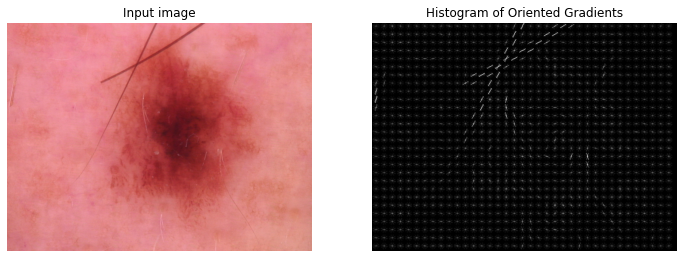

In [24]:
from skimage.feature import hog
from skimage import data, exposure
from skimage.io import imread, imshow

image = imread("HAM10000_images_part_1\ISIC_0024306.jpg")

fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [25]:
main_data.head()

,Unnamed: 0,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,3208,HAM_0006159,ISIC_0028977.jpg,bkl,consensus,50.0,female,upper extremity,vidir_modern
1,1984,HAM_0007201,ISIC_0026208.jpg,nv,follow_up,50.0,male,lower extremity,vidir_molemax
2,2550,HAM_0004889,ISIC_0028511.jpg,bkl,histo,75.0,male,upper extremity,rosendahl
3,1334,HAM_0003302,ISIC_0032434.jpg,nv,follow_up,70.0,male,lower extremity,vidir_molemax
4,643,HAM_0005953,ISIC_0033534.jpg,mel,histo,35.0,female,upper extremity,vidir_modern


In [23]:

import os
import shutil

source_folder = 'dataset/train/'
destination_folder = 'data/'
 
allfiles = os.listdir(source_folder)
 
for f in allfiles:
    os.rename(source_folder + f, destination_folder + f)


In [24]:

source_folder = 'dataset/test/'
destination_folder = 'data/'
 
allfiles = os.listdir(source_folder)
 
for f in allfiles:
    os.rename(source_folder + f, destination_folder + f)


In [25]:
def hair_remove(image):
    # convert image to grayScale
    grayScale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # kernel for morphologyEx
    kernel = cv2.getStructuringElement(1,(17,17))
    
    # apply MORPH_BLACKHAT to grayScale image
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    
    # apply thresholding to blackhat
    _,threshold = cv2.threshold(blackhat,10,255,cv2.THRESH_BINARY)
    
    # inpaint with original image and threshold image
    final_image = cv2.inpaint(image,threshold,1,cv2.INPAINT_TELEA)

    return final_image

In [26]:
from skimage.feature import hog

images = []
labels=[]

SIZE = 256

for directory_path in glob.glob("data//"):
    for img_path,j in zip(glob.glob(os.path.join(directory_path, "*.jpg")), os.listdir("images_data/")):   
        print(img_path)
        img = cv2.imread(img_path) #Reading color images
        img = cv2.resize(img, (SIZE, SIZE)) #Resize images
        img = hair_remove(img)
        img = hog(img,orientations=9,pixels_per_cell=(8,8),visualize=False,cells_per_block=(3,3),channel_axis=-1)
        images.append(img)
        labels.append(main_data.loc[main_data['image_id'] == j, 'dx'].iloc[0])

images_data\ISIC_0024309.jpg
images_data\ISIC_0024310.jpg
images_data\ISIC_0024312.jpg
images_data\ISIC_0024313.jpg
images_data\ISIC_0024315.jpg
images_data\ISIC_0024322.jpg
images_data\ISIC_0024323.jpg
images_data\ISIC_0024324.jpg
images_data\ISIC_0024327.jpg
images_data\ISIC_0024331.jpg
images_data\ISIC_0024332.jpg
images_data\ISIC_0024333.jpg
images_data\ISIC_0024336.jpg
images_data\ISIC_0024337.jpg
images_data\ISIC_0024338.jpg
images_data\ISIC_0024345.jpg
images_data\ISIC_0024346.jpg
images_data\ISIC_0024348.jpg
images_data\ISIC_0024351.jpg
images_data\ISIC_0024357.jpg
images_data\ISIC_0024358.jpg
images_data\ISIC_0024360.jpg
images_data\ISIC_0024364.jpg
images_data\ISIC_0024365.jpg
images_data\ISIC_0024367.jpg
images_data\ISIC_0024369.jpg
images_data\ISIC_0024371.jpg
images_data\ISIC_0024374.jpg
images_data\ISIC_0024376.jpg
images_data\ISIC_0024379.jpg
images_data\ISIC_0024381.jpg
images_data\ISIC_0024382.jpg
images_data\ISIC_0024383.jpg
images_data\ISIC_0024392.jpg
images_data\IS

images_data\ISIC_0025031.jpg
images_data\ISIC_0025032.jpg
images_data\ISIC_0025033.jpg
images_data\ISIC_0025035.jpg
images_data\ISIC_0025038.jpg
images_data\ISIC_0025040.jpg
images_data\ISIC_0025041.jpg
images_data\ISIC_0025044.jpg
images_data\ISIC_0025046.jpg
images_data\ISIC_0025052.jpg
images_data\ISIC_0025053.jpg
images_data\ISIC_0025054.jpg
images_data\ISIC_0025056.jpg
images_data\ISIC_0025057.jpg
images_data\ISIC_0025063.jpg
images_data\ISIC_0025064.jpg
images_data\ISIC_0025066.jpg
images_data\ISIC_0025068.jpg
images_data\ISIC_0025075.jpg
images_data\ISIC_0025076.jpg
images_data\ISIC_0025079.jpg
images_data\ISIC_0025080.jpg
images_data\ISIC_0025081.jpg
images_data\ISIC_0025082.jpg
images_data\ISIC_0025083.jpg
images_data\ISIC_0025084.jpg
images_data\ISIC_0025085.jpg
images_data\ISIC_0025086.jpg
images_data\ISIC_0025090.jpg
images_data\ISIC_0025093.jpg
images_data\ISIC_0025095.jpg
images_data\ISIC_0025097.jpg
images_data\ISIC_0025099.jpg
images_data\ISIC_0025102.jpg
images_data\IS

images_data\ISIC_0025805.jpg
images_data\ISIC_0025806.jpg
images_data\ISIC_0025810.jpg
images_data\ISIC_0025813.jpg
images_data\ISIC_0025814.jpg
images_data\ISIC_0025815.jpg
images_data\ISIC_0025818.jpg
images_data\ISIC_0025819.jpg
images_data\ISIC_0025822.jpg
images_data\ISIC_0025824.jpg
images_data\ISIC_0025826.jpg
images_data\ISIC_0025830.jpg
images_data\ISIC_0025832.jpg
images_data\ISIC_0025833.jpg
images_data\ISIC_0025835.jpg
images_data\ISIC_0025837.jpg
images_data\ISIC_0025838.jpg
images_data\ISIC_0025842.jpg
images_data\ISIC_0025843.jpg
images_data\ISIC_0025849.jpg
images_data\ISIC_0025851.jpg
images_data\ISIC_0025856.jpg
images_data\ISIC_0025861.jpg
images_data\ISIC_0025866.jpg
images_data\ISIC_0025867.jpg
images_data\ISIC_0025868.jpg
images_data\ISIC_0025874.jpg
images_data\ISIC_0025876.jpg
images_data\ISIC_0025877.jpg
images_data\ISIC_0025878.jpg
images_data\ISIC_0025879.jpg
images_data\ISIC_0025883.jpg
images_data\ISIC_0025885.jpg
images_data\ISIC_0025891.jpg
images_data\IS

images_data\ISIC_0026606.jpg
images_data\ISIC_0026607.jpg
images_data\ISIC_0026613.jpg
images_data\ISIC_0026614.jpg
images_data\ISIC_0026620.jpg
images_data\ISIC_0026621.jpg
images_data\ISIC_0026622.jpg
images_data\ISIC_0026623.jpg
images_data\ISIC_0026631.jpg
images_data\ISIC_0026634.jpg
images_data\ISIC_0026637.jpg
images_data\ISIC_0026641.jpg
images_data\ISIC_0026643.jpg
images_data\ISIC_0026644.jpg
images_data\ISIC_0026647.jpg
images_data\ISIC_0026651.jpg
images_data\ISIC_0026652.jpg
images_data\ISIC_0026656.jpg
images_data\ISIC_0026659.jpg
images_data\ISIC_0026661.jpg
images_data\ISIC_0026663.jpg
images_data\ISIC_0026664.jpg
images_data\ISIC_0026668.jpg
images_data\ISIC_0026675.jpg
images_data\ISIC_0026679.jpg
images_data\ISIC_0026681.jpg
images_data\ISIC_0026682.jpg
images_data\ISIC_0026687.jpg
images_data\ISIC_0026689.jpg
images_data\ISIC_0026690.jpg
images_data\ISIC_0026694.jpg
images_data\ISIC_0026696.jpg
images_data\ISIC_0026697.jpg
images_data\ISIC_0026700.jpg
images_data\IS

images_data\ISIC_0027324.jpg
images_data\ISIC_0027326.jpg
images_data\ISIC_0027327.jpg
images_data\ISIC_0027328.jpg
images_data\ISIC_0027331.jpg
images_data\ISIC_0027332.jpg
images_data\ISIC_0027333.jpg
images_data\ISIC_0027335.jpg
images_data\ISIC_0027337.jpg
images_data\ISIC_0027339.jpg
images_data\ISIC_0027344.jpg
images_data\ISIC_0027347.jpg
images_data\ISIC_0027350.jpg
images_data\ISIC_0027352.jpg
images_data\ISIC_0027354.jpg
images_data\ISIC_0027355.jpg
images_data\ISIC_0027356.jpg
images_data\ISIC_0027359.jpg
images_data\ISIC_0027365.jpg
images_data\ISIC_0027367.jpg
images_data\ISIC_0027370.jpg
images_data\ISIC_0027371.jpg
images_data\ISIC_0027373.jpg
images_data\ISIC_0027374.jpg
images_data\ISIC_0027375.jpg
images_data\ISIC_0027384.jpg
images_data\ISIC_0027387.jpg
images_data\ISIC_0027388.jpg
images_data\ISIC_0027389.jpg
images_data\ISIC_0027392.jpg
images_data\ISIC_0027394.jpg
images_data\ISIC_0027400.jpg
images_data\ISIC_0027402.jpg
images_data\ISIC_0027405.jpg
images_data\IS

images_data\ISIC_0028111.jpg
images_data\ISIC_0028113.jpg
images_data\ISIC_0028114.jpg
images_data\ISIC_0028120.jpg
images_data\ISIC_0028121.jpg
images_data\ISIC_0028122.jpg
images_data\ISIC_0028123.jpg
images_data\ISIC_0028124.jpg
images_data\ISIC_0028126.jpg
images_data\ISIC_0028127.jpg
images_data\ISIC_0028136.jpg
images_data\ISIC_0028137.jpg
images_data\ISIC_0028142.jpg
images_data\ISIC_0028147.jpg
images_data\ISIC_0028148.jpg
images_data\ISIC_0028155.jpg
images_data\ISIC_0028156.jpg
images_data\ISIC_0028160.jpg
images_data\ISIC_0028164.jpg
images_data\ISIC_0028165.jpg
images_data\ISIC_0028168.jpg
images_data\ISIC_0028173.jpg
images_data\ISIC_0028175.jpg
images_data\ISIC_0028177.jpg
images_data\ISIC_0028180.jpg
images_data\ISIC_0028184.jpg
images_data\ISIC_0028185.jpg
images_data\ISIC_0028196.jpg
images_data\ISIC_0028197.jpg
images_data\ISIC_0028198.jpg
images_data\ISIC_0028200.jpg
images_data\ISIC_0028201.jpg
images_data\ISIC_0028209.jpg
images_data\ISIC_0028211.jpg
images_data\IS

images_data\ISIC_0028916.jpg
images_data\ISIC_0028917.jpg
images_data\ISIC_0028920.jpg
images_data\ISIC_0028921.jpg
images_data\ISIC_0028924.jpg
images_data\ISIC_0028925.jpg
images_data\ISIC_0028928.jpg
images_data\ISIC_0028929.jpg
images_data\ISIC_0028930.jpg
images_data\ISIC_0028931.jpg
images_data\ISIC_0028932.jpg
images_data\ISIC_0028933.jpg
images_data\ISIC_0028935.jpg
images_data\ISIC_0028936.jpg
images_data\ISIC_0028937.jpg
images_data\ISIC_0028939.jpg
images_data\ISIC_0028943.jpg
images_data\ISIC_0028952.jpg
images_data\ISIC_0028958.jpg
images_data\ISIC_0028962.jpg
images_data\ISIC_0028964.jpg
images_data\ISIC_0028965.jpg
images_data\ISIC_0028967.jpg
images_data\ISIC_0028968.jpg
images_data\ISIC_0028969.jpg
images_data\ISIC_0028970.jpg
images_data\ISIC_0028972.jpg
images_data\ISIC_0028973.jpg
images_data\ISIC_0028975.jpg
images_data\ISIC_0028977.jpg
images_data\ISIC_0028978.jpg
images_data\ISIC_0028980.jpg
images_data\ISIC_0028984.jpg
images_data\ISIC_0028985.jpg
images_data\IS

images_data\ISIC_0029633.jpg
images_data\ISIC_0029637.jpg
images_data\ISIC_0029642.jpg
images_data\ISIC_0029644.jpg
images_data\ISIC_0029647.jpg
images_data\ISIC_0029651.jpg
images_data\ISIC_0029652.jpg
images_data\ISIC_0029655.jpg
images_data\ISIC_0029660.jpg
images_data\ISIC_0029669.jpg
images_data\ISIC_0029674.jpg
images_data\ISIC_0029675.jpg
images_data\ISIC_0029676.jpg
images_data\ISIC_0029678.jpg
images_data\ISIC_0029680.jpg
images_data\ISIC_0029682.jpg
images_data\ISIC_0029683.jpg
images_data\ISIC_0029685.jpg
images_data\ISIC_0029687.jpg
images_data\ISIC_0029689.jpg
images_data\ISIC_0029697.jpg
images_data\ISIC_0029698.jpg
images_data\ISIC_0029699.jpg
images_data\ISIC_0029701.jpg
images_data\ISIC_0029703.jpg
images_data\ISIC_0029705.jpg
images_data\ISIC_0029708.jpg
images_data\ISIC_0029726.jpg
images_data\ISIC_0029729.jpg
images_data\ISIC_0029731.jpg
images_data\ISIC_0029740.jpg
images_data\ISIC_0029741.jpg
images_data\ISIC_0029744.jpg
images_data\ISIC_0029745.jpg
images_data\IS

images_data\ISIC_0030470.jpg
images_data\ISIC_0030477.jpg
images_data\ISIC_0030481.jpg
images_data\ISIC_0030483.jpg
images_data\ISIC_0030484.jpg
images_data\ISIC_0030486.jpg
images_data\ISIC_0030488.jpg
images_data\ISIC_0030490.jpg
images_data\ISIC_0030493.jpg
images_data\ISIC_0030501.jpg
images_data\ISIC_0030502.jpg
images_data\ISIC_0030507.jpg
images_data\ISIC_0030509.jpg
images_data\ISIC_0030511.jpg
images_data\ISIC_0030512.jpg
images_data\ISIC_0030514.jpg
images_data\ISIC_0030517.jpg
images_data\ISIC_0030518.jpg
images_data\ISIC_0030519.jpg
images_data\ISIC_0030521.jpg
images_data\ISIC_0030522.jpg
images_data\ISIC_0030523.jpg
images_data\ISIC_0030524.jpg
images_data\ISIC_0030526.jpg
images_data\ISIC_0030528.jpg
images_data\ISIC_0030533.jpg
images_data\ISIC_0030536.jpg
images_data\ISIC_0030538.jpg
images_data\ISIC_0030539.jpg
images_data\ISIC_0030540.jpg
images_data\ISIC_0030541.jpg
images_data\ISIC_0030542.jpg
images_data\ISIC_0030547.jpg
images_data\ISIC_0030550.jpg
images_data\IS

images_data\ISIC_0031272.jpg
images_data\ISIC_0031277.jpg
images_data\ISIC_0031279.jpg
images_data\ISIC_0031282.jpg
images_data\ISIC_0031284.jpg
images_data\ISIC_0031287.jpg
images_data\ISIC_0031288.jpg
images_data\ISIC_0031289.jpg
images_data\ISIC_0031291.jpg
images_data\ISIC_0031294.jpg
images_data\ISIC_0031295.jpg
images_data\ISIC_0031297.jpg
images_data\ISIC_0031298.jpg
images_data\ISIC_0031303.jpg
images_data\ISIC_0031310.jpg
images_data\ISIC_0031313.jpg
images_data\ISIC_0031318.jpg
images_data\ISIC_0031319.jpg
images_data\ISIC_0031321.jpg
images_data\ISIC_0031325.jpg
images_data\ISIC_0031326.jpg
images_data\ISIC_0031329.jpg
images_data\ISIC_0031330.jpg
images_data\ISIC_0031331.jpg
images_data\ISIC_0031332.jpg
images_data\ISIC_0031334.jpg
images_data\ISIC_0031339.jpg
images_data\ISIC_0031345.jpg
images_data\ISIC_0031349.jpg
images_data\ISIC_0031350.jpg
images_data\ISIC_0031351.jpg
images_data\ISIC_0031352.jpg
images_data\ISIC_0031355.jpg
images_data\ISIC_0031357.jpg
images_data\IS

images_data\ISIC_0032022.jpg
images_data\ISIC_0032024.jpg
images_data\ISIC_0032025.jpg
images_data\ISIC_0032030.jpg
images_data\ISIC_0032031.jpg
images_data\ISIC_0032036.jpg
images_data\ISIC_0032039.jpg
images_data\ISIC_0032040.jpg
images_data\ISIC_0032043.jpg
images_data\ISIC_0032044.jpg
images_data\ISIC_0032045.jpg
images_data\ISIC_0032046.jpg
images_data\ISIC_0032048.jpg
images_data\ISIC_0032051.jpg
images_data\ISIC_0032056.jpg
images_data\ISIC_0032059.jpg
images_data\ISIC_0032060.jpg
images_data\ISIC_0032061.jpg
images_data\ISIC_0032063.jpg
images_data\ISIC_0032066.jpg
images_data\ISIC_0032070.jpg
images_data\ISIC_0032071.jpg
images_data\ISIC_0032072.jpg
images_data\ISIC_0032073.jpg
images_data\ISIC_0032079.jpg
images_data\ISIC_0032081.jpg
images_data\ISIC_0032087.jpg
images_data\ISIC_0032088.jpg
images_data\ISIC_0032091.jpg
images_data\ISIC_0032092.jpg
images_data\ISIC_0032095.jpg
images_data\ISIC_0032098.jpg
images_data\ISIC_0032099.jpg
images_data\ISIC_0032100.jpg
images_data\IS

images_data\ISIC_0032768.jpg
images_data\ISIC_0032773.jpg
images_data\ISIC_0032774.jpg
images_data\ISIC_0032776.jpg
images_data\ISIC_0032777.jpg
images_data\ISIC_0032778.jpg
images_data\ISIC_0032782.jpg
images_data\ISIC_0032790.jpg
images_data\ISIC_0032797.jpg
images_data\ISIC_0032799.jpg
images_data\ISIC_0032804.jpg
images_data\ISIC_0032806.jpg
images_data\ISIC_0032807.jpg
images_data\ISIC_0032808.jpg
images_data\ISIC_0032810.jpg
images_data\ISIC_0032812.jpg
images_data\ISIC_0032816.jpg
images_data\ISIC_0032823.jpg
images_data\ISIC_0032826.jpg
images_data\ISIC_0032827.jpg
images_data\ISIC_0032829.jpg
images_data\ISIC_0032833.jpg
images_data\ISIC_0032834.jpg
images_data\ISIC_0032835.jpg
images_data\ISIC_0032836.jpg
images_data\ISIC_0032840.jpg
images_data\ISIC_0032841.jpg
images_data\ISIC_0032842.jpg
images_data\ISIC_0032843.jpg
images_data\ISIC_0032844.jpg
images_data\ISIC_0032845.jpg
images_data\ISIC_0032847.jpg
images_data\ISIC_0032850.jpg
images_data\ISIC_0032856.jpg
images_data\IS

images_data\ISIC_0033520.jpg
images_data\ISIC_0033522.jpg
images_data\ISIC_0033523.jpg
images_data\ISIC_0033524.jpg
images_data\ISIC_0033526.jpg
images_data\ISIC_0033528.jpg
images_data\ISIC_0033529.jpg
images_data\ISIC_0033531.jpg
images_data\ISIC_0033533.jpg
images_data\ISIC_0033534.jpg
images_data\ISIC_0033538.jpg
images_data\ISIC_0033539.jpg
images_data\ISIC_0033545.jpg
images_data\ISIC_0033546.jpg
images_data\ISIC_0033551.jpg
images_data\ISIC_0033553.jpg
images_data\ISIC_0033559.jpg
images_data\ISIC_0033560.jpg
images_data\ISIC_0033562.jpg
images_data\ISIC_0033568.jpg
images_data\ISIC_0033569.jpg
images_data\ISIC_0033570.jpg
images_data\ISIC_0033571.jpg
images_data\ISIC_0033573.jpg
images_data\ISIC_0033575.jpg
images_data\ISIC_0033576.jpg
images_data\ISIC_0033578.jpg
images_data\ISIC_0033579.jpg
images_data\ISIC_0033581.jpg
images_data\ISIC_0033582.jpg
images_data\ISIC_0033583.jpg
images_data\ISIC_0033586.jpg
images_data\ISIC_0033587.jpg
images_data\ISIC_0033592.jpg
images_data\IS

images_data\ISIC_0034246.jpg
images_data\ISIC_0034252.jpg
images_data\ISIC_0034253.jpg
images_data\ISIC_0034255.jpg
images_data\ISIC_0034256.jpg
images_data\ISIC_0034259.jpg
images_data\ISIC_0034262.jpg
images_data\ISIC_0034263.jpg
images_data\ISIC_0034269.jpg
images_data\ISIC_0034275.jpg
images_data\ISIC_0034276.jpg
images_data\ISIC_0034280.jpg
images_data\ISIC_0034283.jpg
images_data\ISIC_0034284.jpg
images_data\ISIC_0034287.jpg
images_data\ISIC_0034289.jpg
images_data\ISIC_0034291.jpg
images_data\ISIC_0034294.jpg
images_data\ISIC_0034296.jpg
images_data\ISIC_0034299.jpg
images_data\ISIC_0034303.jpg
images_data\ISIC_0034306.jpg
images_data\ISIC_0034313.jpg
images_data\ISIC_0034315.jpg
images_data\ISIC_0034316.jpg
images_data\ISIC_0034317.jpg
images_data\ISIC_0034318.jpg


In [27]:
x_train, x_test, y_train, y_test = train_test_split(images,labels,test_size=0.2,random_state=42, stratify=labels)

In [28]:
Xtrain = np.array(x_train)
Xtest = np.array(x_test)
Xtrain = Xtrain/255
Xtest = Xtest/255
ytrain = np.array(y_train)
ytest = np.array(y_test)

In [31]:
from sklearn import preprocessing
  
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
  
# Encode labels in column 'species'.
ytest= label_encoder.fit_transform(ytest)

In [32]:
ytrain= label_encoder.fit_transform(ytrain)

# Support vector machine

In [33]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.model_selection import GridSearchCV

In [34]:
model = SVC(decision_function_shape='ovo',class_weight='balanced')
model.fit(Xtrain,ytrain)

SVC(class_weight='balanced', decision_function_shape='ovo')

In [35]:
test_prediction = model.predict(Xtest)

In [36]:
print(classification_report(ytest, test_prediction))

              precision    recall  f1-score   support

           0       0.74      0.19      0.31       103
           1       0.45      0.52      0.48       220
           2       0.56      0.57      0.56       223
           3       0.71      0.84      0.77       200

    accuracy                           0.58       746
   macro avg       0.62      0.53      0.53       746
weighted avg       0.59      0.58      0.56       746



## Hyperparamter tunning of SVM

In [37]:
grid = {'C': [0.1, 1],
        'gamma': [0.1, 0.01]}

In [38]:
best_svc = GridSearchCV(estimator=model, param_grid=grid, cv= 3,n_jobs=-1)
best_svc.fit(Xtrain,ytrain)

GridSearchCV(cv=3,
             estimator=SVC(class_weight='balanced',
                           decision_function_shape='ovo'),
             n_jobs=-1, param_grid={'C': [0.1, 1], 'gamma': [0.1, 0.01]})

In [39]:
best_svc.best_params_

{'C': 1, 'gamma': 0.1}

In [40]:
svm=SVC(decision_function_shape='ovo',**best_svc.best_params_,class_weight='balanced')
svm.fit(Xtrain,ytrain)

SVC(C=1, class_weight='balanced', decision_function_shape='ovo', gamma=0.1)

In [41]:
pred=svm.predict(Xtest)
print(classification_report(ytest, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       103
           1       0.00      0.00      0.00       220
           2       0.30      1.00      0.46       223
           3       0.00      0.00      0.00       200

    accuracy                           0.30       746
   macro avg       0.07      0.25      0.12       746
weighted avg       0.09      0.30      0.14       746



# Logistic regression

In [42]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', class_weight='balanced')
model.fit(Xtrain,ytrain)

LogisticRegression(class_weight='balanced', multi_class='multinomial')

In [43]:
pred=model.predict(Xtest)

In [44]:
print(classification_report(ytest, pred))

              precision    recall  f1-score   support

           0       0.27      0.50      0.35       103
           1       0.42      0.21      0.28       220
           2       0.52      0.24      0.33       223
           3       0.45      0.76      0.56       200

    accuracy                           0.41       746
   macro avg       0.41      0.43      0.38       746
weighted avg       0.44      0.41      0.38       746



## Hyperparamter tunning of Logistic regression

In [45]:
grid={"C":np.logspace(-4,4,7), "penalty":["l1","l2"]}


In [46]:
best_lr = GridSearchCV(estimator=model, param_grid=grid, cv= 3,n_jobs=-1)
best_lr.fit(x_train, y_train)

GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          multi_class='multinomial'),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 2.15443469e-03, 4.64158883e-02, 1.00000000e+00,
       2.15443469e+01, 4.64158883e+02, 1.00000000e+04]),
                         'penalty': ['l1', 'l2']})

In [47]:
best_lr.best_params_

{'C': 0.002154434690031882, 'penalty': 'l2'}

In [48]:
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', class_weight='balanced',**best_lr.best_params_)
lr.fit(Xtrain,ytrain)

LogisticRegression(C=0.002154434690031882, class_weight='balanced',
                   multi_class='multinomial')

In [49]:
pred=lr.predict(Xtest)
print(classification_report(ytest, pred))

              precision    recall  f1-score   support

           0       0.27      0.50      0.35       103
           1       0.41      0.20      0.27       220
           2       0.51      0.22      0.31       223
           3       0.44      0.76      0.55       200

    accuracy                           0.40       746
   macro avg       0.41      0.42      0.37       746
weighted avg       0.43      0.40      0.37       746



# Stacking classifier

In [50]:
clf1 = KNeighborsClassifier(n_neighbors=4)
clf2 = RandomForestClassifier(class_weight='balanced')
clf3 = MultinomialNB()
lr = LogisticRegression(multi_class='multinomial',class_weight='balanced')


In [51]:
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
                          meta_classifier=lr)

print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf], 
                      ['KNN', 
                       'Random Forest', 
                       'Naive Bayes',
                       'StackingClassifier']):

    scores = model_selection.cross_val_score(clf, x_train, y_train, 
                                              cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy: 0.29 (+/- 0.01) [KNN]
Accuracy: 0.48 (+/- 0.01) [Random Forest]
Accuracy: 0.42 (+/- 0.01) [Naive Bayes]
Accuracy: nan (+/- nan) [StackingClassifier]


In [52]:
sclf.fit(Xtrain,ytrain)

StackingClassifier(classifiers=[KNeighborsClassifier(n_neighbors=4),
                                RandomForestClassifier(class_weight='balanced'),
                                MultinomialNB()],
                   meta_classifier=LogisticRegression(class_weight='balanced',
                                                      multi_class='multinomial'))

In [54]:
pred=sclf.predict(Xtest)
print(classification_report(ytest, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       103
           1       0.42      0.51      0.46       220
           2       0.48      0.52      0.50       223
           3       0.65      0.78      0.71       200

    accuracy                           0.51       746
   macro avg       0.39      0.45      0.42       746
weighted avg       0.44      0.51      0.48       746



## Stacking classifier using grid search

In [55]:
params = {'kneighborsclassifier__n_neighbors': [1, 5],
          'randomforestclassifier__n_estimators': [10, 50],
          'meta_classifier__C': [0.1, 10.0]}

grid = GridSearchCV(estimator=sclf, 
                    param_grid=params, 
                    cv=5,
                    refit=True)
grid.fit(Xtrain,ytrain)

cv_keys = ('mean_test_score', 'std_test_score', 'params')

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_[cv_keys[0]][r],
             grid.cv_results_[cv_keys[1]][r] / 2.0,
             grid.cv_results_[cv_keys[2]][r]))

0.359 +/- 0.01 {'kneighborsclassifier__n_neighbors': 1, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 10}
0.388 +/- 0.01 {'kneighborsclassifier__n_neighbors': 1, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 50}
0.317 +/- 0.01 {'kneighborsclassifier__n_neighbors': 1, 'meta_classifier__C': 10.0, 'randomforestclassifier__n_estimators': 10}
0.428 +/- 0.01 {'kneighborsclassifier__n_neighbors': 1, 'meta_classifier__C': 10.0, 'randomforestclassifier__n_estimators': 50}
0.379 +/- 0.01 {'kneighborsclassifier__n_neighbors': 5, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 10}
0.461 +/- 0.01 {'kneighborsclassifier__n_neighbors': 5, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 50}
0.381 +/- 0.01 {'kneighborsclassifier__n_neighbors': 5, 'meta_classifier__C': 10.0, 'randomforestclassifier__n_estimators': 10}
0.445 +/- 0.00 {'kneighborsclassifier__n_neighbors': 5, 'meta_classifier__C': 10.0, 'randomforestclassifier_

In [56]:
print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

Best parameters: {'kneighborsclassifier__n_neighbors': 5, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 50}
Accuracy: 0.46


In [58]:
pred=grid.predict(Xtest)
print(classification_report(ytest, pred))

              precision    recall  f1-score   support

           0       0.50      0.02      0.04       103
           1       0.33      0.43      0.37       220
           2       0.40      0.40      0.40       223
           3       0.61      0.71      0.66       200

    accuracy                           0.44       746
   macro avg       0.46      0.39      0.37       746
weighted avg       0.45      0.44      0.41       746



# Random forest classifier

In [59]:
from sklearn.ensemble import RandomForestClassifier

rfc=RandomForestClassifier(random_state=42)
rfc.fit(Xtrain,ytrain)

RandomForestClassifier(random_state=42)

In [60]:
pred=model.predict(Xtest)
print(classification_report(ytest, pred))

              precision    recall  f1-score   support

           0       0.27      0.50      0.35       103
           1       0.42      0.21      0.28       220
           2       0.52      0.24      0.33       223
           3       0.45      0.76      0.56       200

    accuracy                           0.41       746
   macro avg       0.41      0.43      0.38       746
weighted avg       0.44      0.41      0.38       746



## Hyperparamter tunning of Random forest

In [61]:
param_grid = { 
    'n_estimators': [50,60,70,80,90,100],
    'max_depth' : [4,5,6,7,8]
}

In [62]:
best_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 3,n_jobs=-1)
best_rfc.fit(Xtrain,ytrain)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'n_estimators': [50, 60, 70, 80, 90, 100]})

In [63]:
best_rfc.best_params_

{'max_depth': 4, 'n_estimators': 90}

In [66]:
random_forest=RandomForestClassifier(**best_rfc.best_params_)
random_forest.fit(Xtrain,ytrain)

RandomForestClassifier(max_depth=4, n_estimators=90)

In [67]:
pred=random_forest.predict(Xtest)
print(classification_report(ytest, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       103
           1       0.41      0.41      0.41       220
           2       0.51      0.48      0.50       223
           3       0.56      0.89      0.69       200

    accuracy                           0.50       746
   macro avg       0.37      0.44      0.40       746
weighted avg       0.42      0.50      0.45       746

